In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from datetime import datetime
seed=2024

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def get_unit(path,time_before):
    neu_data = NeuronData.from_python_hdf5(path)
    dict_att={'in':{},'out':{}}
    for att,i_att in zip(['in','out'],[1,-1]):
        # get spike matrices in and out conditions
        sp_in, mask_in = align_trials.get_align_tr(
            neu_data, select_block=1, select_pos=i_att, time_before=time_before,event="sample_on"
        )
        if np.mean(sp_in[:,200:1000]) < 5/1000: 
            return None#dict_att[att]= None
        else:
            sp_samples = select_trials.get_sp_by_sample(sp_in[:,:time_before+1000], neu_data.sample_id[mask_in], samples=[0,11,15,55,51])
            sp_samples['path']=path
            sp_samples['n_type']=neu_data.cluster_group
            dict_att[att]=sp_samples
    return dict_att

In [5]:
def get_cv_scores(model, X, y, seed=None,cv=5):
    kfold = KFold(n_splits=cv, shuffle=True,random_state=seed)  # Create KFold object
    train_scores, test_scores = [], []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)  # Train the model on the training fold
        train_scores.append((model.score(X_train,y_train)))  # Record training score
        test_scores.append((model.score(X_test,y_test)))  # Record testing score
    return train_scores,test_scores

In [6]:
def get_lambda_cv_scores(model, X, y, lambdas, seed,cv=5):
    """Compute the mean training and testing scores for each regularization parameter (lambda).
    Args:
        model (sklearn):  model to use.
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.
        lambdas (list): A list of regularization parameters (lambda values) to try.
        cv (int): The number of folds for cross-validation.
    """
    train_scores, test_scores = [], []
    for lam in lambdas:
        model.set_params(alpha=lam)  # Set regularization parameter
        i_train_scores,i_test_scores = get_cv_scores(model, X, y, cv=cv,seed=seed)
        train_scores.append(i_train_scores)
        test_scores.append(i_test_scores )
    return train_scores,test_scores

In [7]:
def select_neurons(i_n,x_in,y_in,x_out=None,y_out=None,time_before=None,win=None,step=None,t_st=None,t_end=None):
    # IN
    idx_neurons = np.random.choice(x_in.shape[0],i_n,replace=False)
    x_in=firing_rate.moving_average(data=x_in, win=win, step=step)[idx_neurons,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
    y_in=firing_rate.moving_average(data=y_in, win=win, step=step)[:,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
    x_in=(x_in.reshape(x_in.shape[0],-1).T)
    y_in=(y_in.reshape(y_in.shape[0],-1).T)
    ss = StandardScaler(with_mean=True, with_std=True)
    x_in=ss.fit_transform(x_in)
    ss = StandardScaler(with_mean=True, with_std=True)
    y_in=ss.fit_transform(y_in)
    if x_out is not None:
        # OUT
        x_out=firing_rate.moving_average(data=x_out, win=win, step=step)[idx_neurons,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
        y_out=firing_rate.moving_average(data=y_out, win=win, step=step)[:,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
        x_out=(x_out.reshape(x_out.shape[0],-1).T)
        y_out=(y_out.reshape(y_out.shape[0],-1).T)
        ss = StandardScaler(with_mean=True, with_std=True)
        x_out=ss.fit_transform(x_out)
        ss = StandardScaler(with_mean=True, with_std=True)
        y_out=ss.fit_transform(y_out)
    return x_in,y_in,x_out,y_out

In [8]:
def run_iteration(units_info,sample,lams,seed,params):
    best_acc =[[],[]]
    np.random.seed(seed=seed)
    step=params['step']
    t_st=params['t_st']
    t_end=params['t_end']
    win=params['win']
    time_before=params['time_before']
    for i_n in tqdm(range(1,units_info['pfc']['in'][sample].shape[0]+1)):
        x_in=units_info['pfc']['in'][sample]
        y_in=units_info['v4']['in'][sample]
        x_out=units_info['pfc']['out'][sample]
        y_out=units_info['v4']['out'][sample]
        x_in,y_in,x_out,y_out=select_neurons(i_n,x_in=x_in,y_in=y_in,x_out=x_out,y_out=y_out,time_before=time_before,win=win,step=step,t_st=t_st,t_end=t_end)
        #f,ax=plt.subplots(1,2,figsize=(10,6),sharey=True)
        for i,(i_x,i_y) in enumerate(zip([x_in,x_out],[y_in,y_out])):
            ridge_model = Ridge(fit_intercept=True)
            train_scores,test_scores=get_lambda_cv_scores(ridge_model, i_x, i_y, lams, seed=seed,cv=10)
            std_score=np.std(test_scores,axis=1)
            mean_score=np.mean(test_scores,axis=1)
            im=np.argmax(mean_score)
            best_acc[i].append(mean_score[im])
    return best_acc

## Read data

In [9]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/"
    )
elif platform.system() == "Windows":
    basepath = 'D:/data/'#"C:/Users/camil/Documents/int/"

In [10]:
comment='Accuracy of predicting V4 activity from PFC activity using linear regression'
session = '2022-12-05_10-51-52'#2022-12-06_11-12-04
areas=['pfc','v4']
subject='Riesling'
time_before=200
step=20
t_st=10
t_end=480
win=100
lams = np.logspace(0, 50, num=50, base=1.4, endpoint=False)* 1e-4
n_iterations=10
params = {"step": step, "t_st": t_st, "t_end": t_end, "win": win, "time_before": time_before}
date=datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [11]:
units_path = {'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath + "session_struct/" + area + "/neurons/*neu.h5"
    path_list = np.array(glob.glob(neu_path))
    mask=[]
    for path in path_list:
        mask.append(session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0])
    path_list=path_list[mask]
    units_path[area]['paths']=path_list
    

In [12]:
area_info={}
for area in areas:
    path_list = units_path[area]['paths']

    info = Parallel(n_jobs=-1)(
        delayed(get_unit)(path_list[i],time_before)for i in tqdm(range(len(path_list)))
    )
    area_info[area] = info

100%|██████████| 73/73 [00:12<00:00,  6.01it/s]


In [13]:
units_info = {'v4':{'in':{},'out':{}},'pfc':{'in':{},'out':{}}}
for area in areas:
    for att in ['in','out']:
        paths,n_type,attention=[],[],[]
        sp11=[]
        sp15=[]
        sp51=[]
        sp55=[]
        sp0=[]
        for i_info in area_info[area]:
            if i_info is not None:
                paths.append(i_info[att]['path'])
                sp11.append(i_info[att]['11'])
                sp15.append(i_info[att]['15'])
                sp51.append(i_info[att]['51'])
                sp55.append(i_info[att]['55'])
                sp0.append(i_info[att]['0'])
                n_type.append(i_info[att]['n_type'])
        units_info[area][att]['paths'] = np.array(paths)
        units_info[area][att]['11'] = np.array(sp11)
        units_info[area][att]['15'] = np.array(sp15)
        units_info[area][att]['51'] = np.array(sp51)
        units_info[area][att]['55'] = np.array(sp55)
        units_info[area][att]['0'] = np.array(sp0)
        units_info[area][att]['n_type'] = np.array(n_type)

## Preproces and test on one model

In [14]:
sample='11'
x_in=units_info['pfc']['in'][sample]
y_in=units_info['v4']['in'][sample]
i_n=x_in.shape[0]
x,y,_,_=select_neurons(i_n,x_in,y_in,x_out=None,y_out=None,time_before=time_before,win=win,step=step,t_st=t_st,t_end=t_end)
print(x.shape)
print(y.shape)

(1224, 27)
(1224, 31)


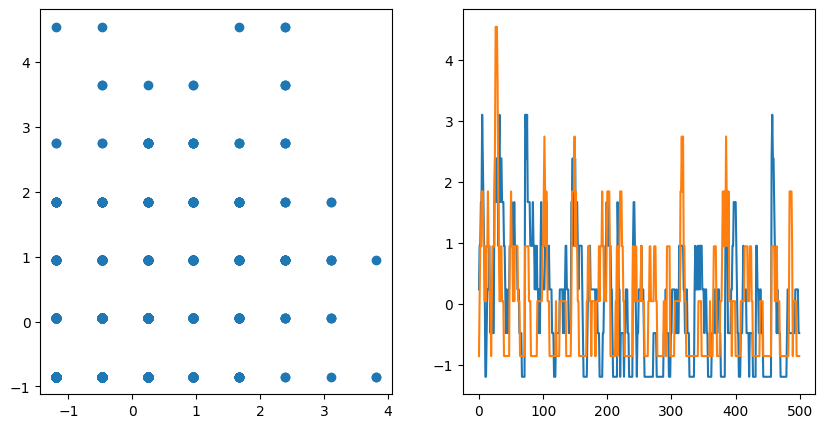

In [15]:
f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x[:,0],x[:,1])
for i in range(2):
    ax[1].plot(x[:500,i])

#### Test result in one condition

0.15150573350181187

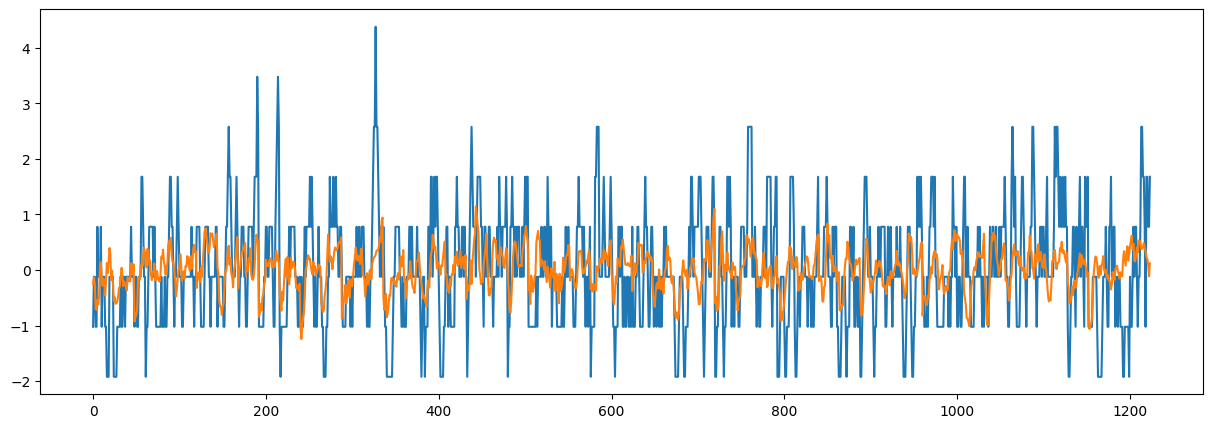

In [16]:
i_n=0
lr_m = LinearRegression( fit_intercept=True,n_jobs=-1)
lr_m.fit(x,y)
y_pred = lr_m.predict(x)
plt.subplots(figsize=(15,5))
plt.plot(y[:1600,i_n])
plt.plot(y_pred[:1600,i_n])
#print(1-metrics.mean_squared_error(y_pred,y))
lr_m.score(x,y)

In [17]:
rng = np.random.RandomState(seed)
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
kf = KFold(n_splits=10, shuffle=True, random_state=seed)
linear_scores = cross_val_score(linear_model, x, y, cv=kf,scoring='r2')

In [18]:
print(linear_scores)
print(np.mean(linear_scores))

[0.07090261 0.11824671 0.10047798 0.08272955 0.11868973 0.09912741
 0.10228058 0.10216141 0.11594577 0.09883936]
0.10094011082886536


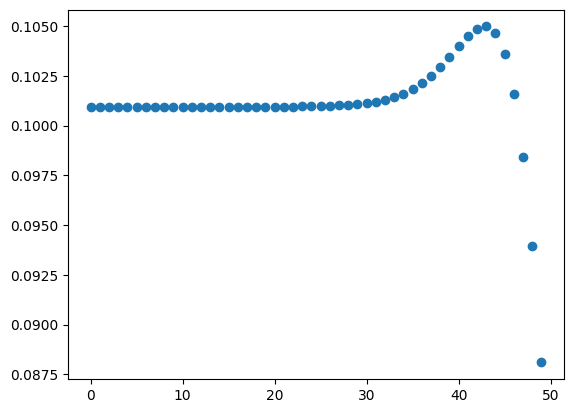

In [19]:
all_scores=[]
for lam in lams:
    rng = np.random.RandomState(seed)
    ridge_model = Ridge(alpha=lam,fit_intercept=True)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    ridge_scores = cross_val_score(ridge_model, x, y, cv=kf,n_jobs=-1,scoring='r2')
    all_scores.append(ridge_scores)
plt.scatter(range(len(lams)),np.mean(all_scores,axis=1))

#### With my functions

In [20]:
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
train_scores,test_scores=get_cv_scores(linear_model, x, y, seed=seed,cv=10)
print((train_scores))
print((test_scores))
mean_train_score = np.mean(train_scores)
print(mean_train_score)
mean_test_score = np.mean(test_scores)
print(mean_test_score)

[0.15612811166969298, 0.1519289690918905, 0.1539244109204571, 0.1557551998912734, 0.15157205744782445, 0.15361828620073098, 0.153651302279659, 0.153217259230572, 0.15236586703920638, 0.1537815433332989]
[0.07090261024921339, 0.11824670602535227, 0.10047798147532676, 0.0827295494143046, 0.11868972993358301, 0.09912740897643184, 0.10228058230545249, 0.10216141354419875, 0.1159457696293484, 0.09883935673544193]
0.15359430071046057
0.10094011082886536


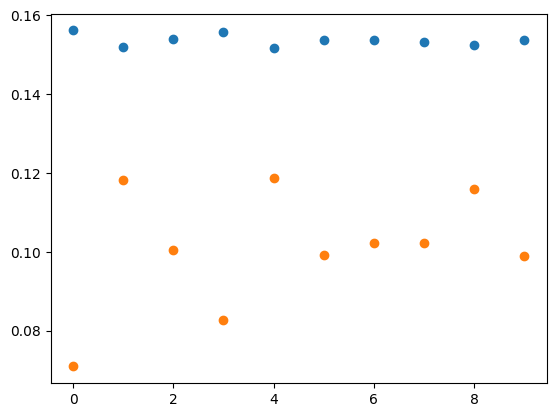

In [21]:
plt.scatter(range(10),train_scores)
plt.scatter(range(10),test_scores)

192.09034394458908
0.10497557940377225


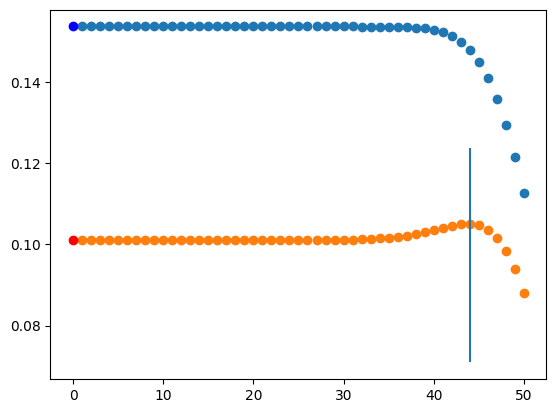

In [22]:
ridge_model = Ridge(fit_intercept=True)
train_scores,test_scores=get_lambda_cv_scores(ridge_model, x, y, lams, seed=seed,cv=10)
# plots
plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1))
plt.scatter([0],[mean_train_score],color='b')
#plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1)-np.std(train_scores,axis=1),'b--')
plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1))
#plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1)+np.std(test_scores,axis=1),'g--')
plt.scatter([0],[mean_test_score],color='r')
im=np.argmax(np.mean(test_scores,axis=1))
plt.vlines(im+1,np.min(test_scores),np.max(test_scores))
print(lams[im])
print(np.mean(test_scores,axis=1)[im])

192.09034394458908
0.10497557940377225


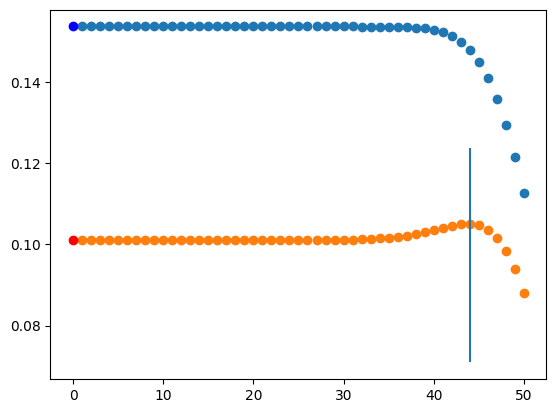

In [23]:
ridge_model = Ridge(fit_intercept=True)
train_scores,test_scores=get_lambda_cv_scores(ridge_model, x, y, lams, seed=seed,cv=10)
# plots
plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1))
plt.scatter([0],[mean_train_score],color='b')
#plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1)-np.std(train_scores,axis=1),'b--')
plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1))
#plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1)+np.std(test_scores,axis=1),'g--')
plt.scatter([0],[mean_test_score],color='r')
im=np.argmax(np.mean(test_scores,axis=1))
plt.vlines(im+1,np.min(test_scores),np.max(test_scores))
print(lams[im])
print(np.mean(test_scores,axis=1)[im])

## Train and Test one model for each condition (* n_iterations)

In [24]:
plt.close()

In [25]:
acc={}
for sample in ['51','11','55','15','0']:
    it_best_acc=[]
    np.random.seed(seed=seed)
    n_seeds = np.random.choice(6000,n_iterations,replace=False)
    data = Parallel(n_jobs=-1)(
        delayed(run_iteration)(
            units_info=units_info, sample=sample, lams=lams, seed=i_seed, params=params
        )
        for i_seed in tqdm(n_seeds)
    )
    it_best_acc=[]
    for i_data in data:
        it_best_acc.append(i_data)
    acc[sample]=it_best_acc
    

100%|██████████| 10/10 [00:00<00:00, 4993.81it/s]


In [26]:
acc['comment']=comment
acc['session']=session
acc['computation_date']=date
for key,value in params.items():
    acc[key]=value

In [27]:
# to_python_hdf5(dat=[acc], save_path='./test.h5')
# data=from_python_hdf5(load_path='./test.h5')

Text(0.5, 0.98, 'predict V4 from PFC linear regression')

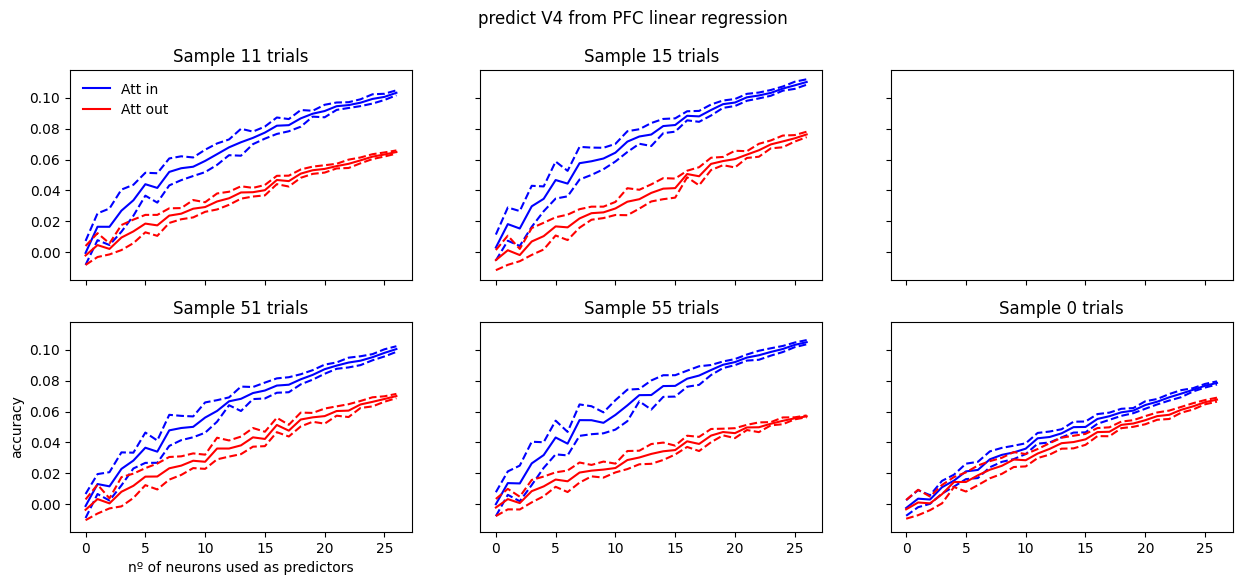

In [39]:
ncols=3
nrows=2
f,ax=plt.subplots(nrows,ncols,figsize=(15,6),sharey=True,sharex=True)
col=[0,1,0,1,2]
row=[0,0,1,1,1]
for isample,irow,icol in zip(['11','15','51','55','0'],row,col):

    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,0],axis=0),'b',label='Att in')
    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,0],axis=0)+np.std(np.array(acc[isample])[:,0],axis=0),'b--')
    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,0],axis=0)-np.std(np.array(acc[isample])[:,0],axis=0),'b--')
    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,1],axis=0),'r',label='Att out')
    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,1],axis=0)+np.std(np.array(acc[isample])[:,1],axis=0),'r--')
    ax[irow,icol].plot(np.mean(np.array(acc[isample])[:,1],axis=0)-np.std(np.array(acc[isample])[:,1],axis=0),'r--')
    ax[irow,icol].set(title='Sample %s trials'%isample)

ax[0,0].legend(fontsize=10, scatterpoints=5, columnspacing=0.5, framealpha=0, loc="best")
ax[1, 0].set(ylabel="accuracy", xlabel="nº of neurons used as predictors")
f.suptitle(comment)

In [50]:
path = (session
    + "_"
    + subject
    + "_"
    + "predict_%s_from_%s_"%(area_y, area_x)
    + date
    + ".h5"
)
path 

'2022-12-05_10-51-52_Riesling_predict_pfc_from_v4_01/05/2024 09:56:24.h5'

In [52]:
datetime.now().strftime("%d/%m/%Y_%H:%M:%S")


'2024-05-01_10-46-04'

In [44]:
area_x = "v4"
area_y = "pfc"